## 6.S083 / 18.S190
# PSET 2 Solution – Recovery Modeling


----

## Exercise 1: Frequencies

In this exercise we will write a general function to count occurrences of values in a set of data

### 1. Write a function `counts` that:
+ accepts a vector `data` 
+ calculates the number of times each value in `data` occurs

In [1]:
function counts(data::Vector)
  d = Dict{Int, Int}()
  
  for cur_value in data
    if haskey(d, cur_value)
      d[cur_value] += 1
    else
      d[cur_value] = 1
    end
  end
  
  return d
end


counts (generic function with 1 method)

### 2. Test that your code is correct:

+ Apply it to obtain the counts of the data vector

```
vv = [1, 0, 1, 0, 1000, 1, 1, 1000]
```

In [2]:
vv = [1, 0, 1, 0, 1000, 1, 1, 1000]
cc = counts(vv)

@assert cc[0] == 2
@assert cc[1] == 4
@assert cc[1000] == 2


### 3. Extract vectors `ks` of keys and `vs` of values 

+ using the `keys()` and `values()` functions 
+ convert the results into a vector using the `collect` function.


In [3]:
ks = collect(keys(cc))
vs = collect(values(cc))

@assert sort(ks) == [0, 1, 1000]
@assert sort(vs) == [2, 2, 4]


### 4. Define variable `p` as the result of running `sortperm` on `ks`

+ this gives a **permutation** that tells you 
+ in which order you need to take the keys to give a sorted version


In [4]:
# note that you can't do: sortperm(keys(cc))

p = sortperm(ks)


3-element Array{Int64,1}:
 1
 3
 2

### 5. Use indexing `ks[p]` to return the sorted keys/values vectors 


In [5]:
@assert ks[p] == sort(ks)

vs[p]


3-element Array{Int64,1}:
 2
 4
 2

### 6. Test that your new `counts` function gives the correct result

+ make sure output for vector `v` 
+ matches the true result you can derive by hand


In [6]:
function sorted_counts(data::Vector)
  cc = counts(data)
  ks = collect(keys(cc))
  vs = collect(values(cc))
  
  p = sortperm(ks)
  ks .= ks[p]
  vs .= vs[p]
  
  return (ks, vs)
end


sorted_counts (generic function with 1 method)

In [7]:
# vv = [1, 0, 1, 0, 1000, 1, 1, 1000]
sc = sorted_counts(vv)

expected = [(0,2), (1,4), (1000,2)]
k_list, v_list = sc

for (cur_index, (cur_key, cur_value)) in enumerate(expected)
  @assert cur_key == k_list[cur_index]
  @assert cur_value == v_list[cur_index]
end


### 7. Make a function `probability_distribution` 

+ that normalizes result of `counts` to calculate relative frequency
+ the function should return the keys and probabilities


In [8]:
function probability_distribution(data::Vector)
  (ks, vs) = sorted_counts(data)
  
  # implicitly casts as floats
  vs = vs / sum(vs)
  
  return (ks, vs)
end


probability_distribution (generic function with 1 method)

In [9]:
# vv = [1, 0, 1, 0, 1000, 1, 1, 1000]
sc = probability_distribution(vv)

expected = [(0,2/8), (1,4/8), (1000,2/8)]
k_list, v_list = sc

for (cur_index, (cur_key, cur_value)) in enumerate(expected)
  @assert cur_key == k_list[cur_index]
  @assert cur_value == v_list[cur_index]
end

@assert sum(v_list) == 1.0


----

## Exercise 2: Modeling recovery

In this exercise, we will investigate the simple model of recovery from an infection where an individual who is infected has probability $p$ to recover each day. If they recover on day $n$ then $\tau = n$.
We see that $\tau$ is a random variable, so we need to study its **probability distribution**.


----

### 1. Define the function `bernoulli(p)` from lectures. Recall that this generates `true` with probability $p$ and `false` with probability $(1 - p)$.


In [10]:
bernoulli(p) = rand() <= p

bernoulli (generic function with 1 method)

In [11]:
coin_dict = Dict(true=>0, false=>0)

for _ in 1:10000
  @assert bernoulli(1) == true
  @assert bernoulli(0) == false
  
  coin_dict[bernoulli(0.5)] += 1
end

@assert coin_dict[true] > 0
@assert coin_dict[false] > 0


### 2. Write a function `geometric(p)`. 
+ This should run a simulation with probability $p$ to recover 
+ and wait *until* the individual recovers
+ at which point it returns the time taken to recover.


In [12]:
function geometric(p)
  @assert 0 < p <= 1
  
  tau = 1
  while !bernoulli(p)
    tau += 1
  end
  return tau
end


geometric (generic function with 1 method)

In [13]:
# geometric(0) raises error (inf loop)

@assert geometric(1) == 1



### 3. Write a function `experiment(p, N)` 

That runs the function from [2] `N` times and collects the results into a vector.


In [14]:
experiment(p, N) = [ geometric(p) for _ in 1:N ]

@assert experiment(1, 1) == [1]



### 4. Run an experiment with $p=0.25$ and $N=10,000$. 

+ Plot the resulting probability distribution, 
+ i.e. plot $P(\tau = n)$ against $n$, where $n$ is the recovery time.


In [15]:
p = 0.25
N = 10^4

cur_experiment = experiment(p, N)
default_distribution = probability_distribution(cur_experiment)

@assert length(cur_experiment) == N


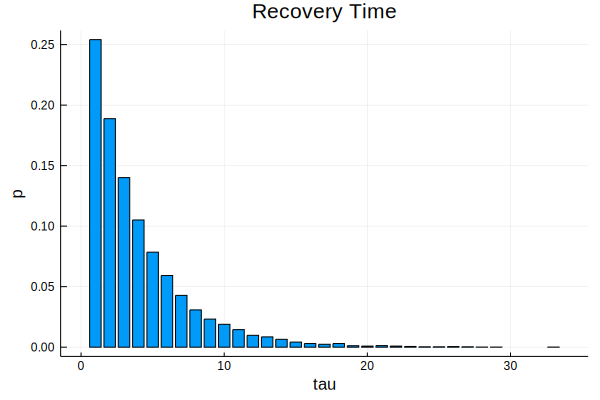

In [16]:
using Plots

dist_plot(cur_distribution) = bar(
  cur_distribution, title="Recovery Time",
  xlabel="tau", ylabel="p", label=""
)

dist_plot(default_distribution)


#### // note that around 25% of population recovered in 1 day

---


### 5. Calculate the mean recovery time and add it to the plot using the `vline!()` function and the `ls=:dash` argument to make a dashed line.


mean recovery is: ~4 days



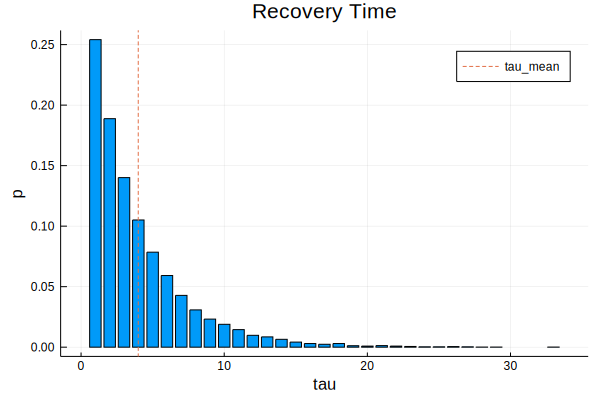

In [17]:
function calc_mean_tau(cur_distribution) 
  mean_tau = 0.0

  for (cur_tau, cur_prob) in zip(cur_distribution...)
    mean_tau += cur_prob * cur_tau
  end

  return mean_tau
  
end

cur_mean_tau = calc_mean_tau(default_distribution)
println("mean recovery is: ~" * string(Int(round(cur_mean_tau))) * " days\n")

dist_plot(default_distribution)
vline!([cur_mean_tau], ls=:dash, label="tau_mean")



### 6. What shape does the distribution seem to have? Can you verify that by using one or more log scales?


#### A: The plot appears to be a [geometric distribution](https://en.wikipedia.org/wiki/Geometric_distribution) 

// the discrete analogue of the exponential distribution

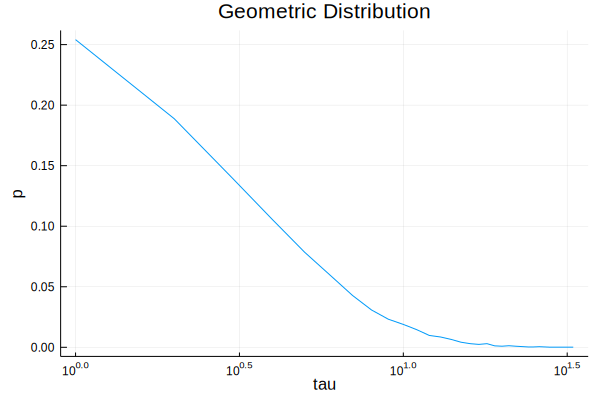

In [18]:
plot(
  default_distribution, title="Geometric Distribution", 
  xlabel="tau", ylabel="p", label="",
  xscale=:log10
)



### 7. Write an interactive visualization that repeats [4] for $p$ varying between $0$ and $1$ and $N$ between $0$ and $100,000$.


In [19]:
function make_recovery_plot(p, N)
  
  cur_experiment = experiment(p, N)
  cur_distribution = probability_distribution(cur_experiment)

  cur_mean_tau = calc_mean_tau(cur_distribution)

  dist_plot(cur_distribution)
  vline!([cur_mean_tau], ls=:dash, label="tau_mean")

end

make_recovery_plot (generic function with 1 method)

In [20]:
using Interact

linspace(a,b,n) = range(a,stop=b,length=n)
logspace(a::Int,b::Int,n) = map(Int,map(round, 10 .^ linspace(log10(a),log10(b),n)))

@manipulate for p in linspace(0,1,11)[2:end], N=logspace(1, 10^5, 6)
  make_recovery_plot(p, N)
end


HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-10720448119153840883\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-6821059649421147054\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-10720448119153840883\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["p"], Dict{Symbol,Any}(:className => "interact ",:style => Dict{Any,Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol,Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol,Any}(:max => 10,:min => 1,:attributes => Dict{Any,Any}(:type => "range",Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}","orient" => "horizontal"),:step => 1,:className => "slider slider is-fullwidth",:style => Dict{Any,Any}()))], Dict{Symbol,Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol,Any}(:className => "interact-flex-row-right"))], Dict{Symbol,Any}(:className => "interact-flex-row interact-widget")), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing),"index" => (Observable{Any} with 2 listeners. Value:
5, nothing)), Set(String[]), nothing, Asset[Asset("js", "knockout", "/Users/dan/.julia/packages/Knockout/IP1uR/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/Users/dan/.julia/packages/Knockout/IP1uR/src/../assets/knockout_punches.js"), Asset("js", nothing, "/Users/dan/.julia/packages/InteractBase/NMcus/src/../assets/all.js"), Asset("css", nothing, "/Users/dan/.julia/packages/InteractBase/NMcus/src/../assets/style.css"), Asset("css", nothing, "/Users/dan/.julia/packages/Interact/SbgIk/src/../assets/bulma_confined.min.css")], Dict{Any,Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")],"index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(sz_max:32,sz_curr:0), Set(AbstractConnection[]), Base.GenericCondition{Base.AlwaysLockedST}(Base.InvasiveLinkedList{Task}(Task (runnable) @0x000000010f59e1d0, Task (runnable) @0x000000010f59e1d0), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"0.1\",\"0.2\",\"0.3\",\"0.4\",\"0.5\",\"0.6\",\"0.7\",\"0.8\",\"0.9\",\"1.0\"],\"changes\":WebIO.getval({\"name\":\"changes\",\"scope\":\"12720328278743025694\",\"id\":\"16196140803580144312\",\"type\":\"observable\"}),\"index\":WebIO.getval({\"name\":\"index

#### As you decrease p, the expected tau tends towards infinity...

----



### 8. Fix $N = 10,000$ and calculate the *mean* time $\langle \tau(p) \rangle$ to recover. 

+ Plot this as a function of $p$.
+ Can you find the relationship between the two quantities?

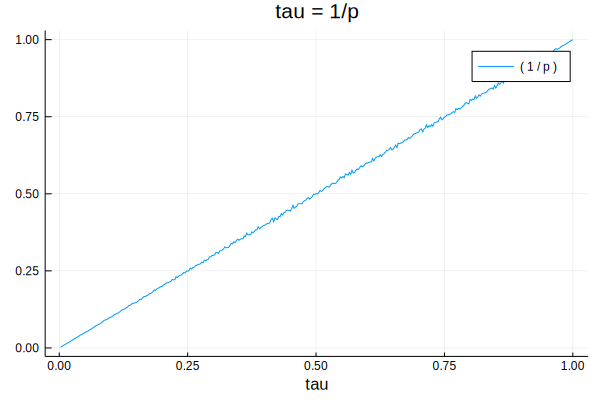

In [21]:
N = 10^4
n = 400

xx = linspace(0,1,n+1)[2:end]
yy = []

for p in xx
  cur_experiment = experiment(p, N)
  cur_distribution = probability_distribution(cur_experiment)

  cur_mean_tau = calc_mean_tau(cur_distribution)
  push!(yy, cur_mean_tau)
end

plot(
  xx, 1 ./ yy, xlabel="tau", 
  label="( 1 / p )", title="tau = 1/p"
)

----

## Exercise 3: More efficient geometric distributions

Let's use the notation $P_n := \mathbb{P}(\tau = n)$ for the probability to recover on the $n$th step.

Probability theory tells us that in the limit of an infinite number of trials, we have the exact results $P_1 = p$, that $P_2 = p (1-p)$, and in general $P_n = p (1 - p)^{n-1}$.

----

### 1. Fix $p = 0.25$. Make a vector of the values $P_n$ for $n=1, \dots, 50$



In [22]:
p = 0.25

max_n = 50
n_list = 1:max_n

P(n) = p * (1-p) ^ (n-1)
P_list = P.(n_list)

@assert P_list[1] == p
@assert P_list[2] == p * (1-p)


### 2. Plot $P_n$ as a function of $n$ and compare it to last exercise



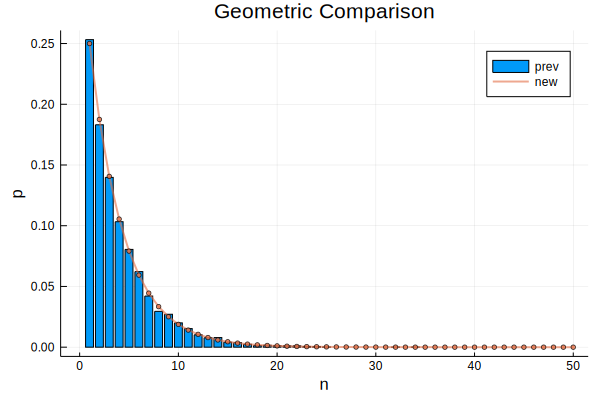

In [23]:
prev_n, prev_P = probability_distribution(experiment(p, N))
bar(prev_n, prev_P, label="prev")

plot!(n_list, P_list, label="new", width=2, opacity=0.6)
scatter!(n_list, P_list, label="", markersize=2.5, opacity=0.8, color=2)

plot!(
  title="Geometric Comparison",
  xlabel="n", ylabel="p"
)

#### (2.i) How could we measure the *error*?

+ i.e. the distance between the two graphs? 
+ What do you think determines it?


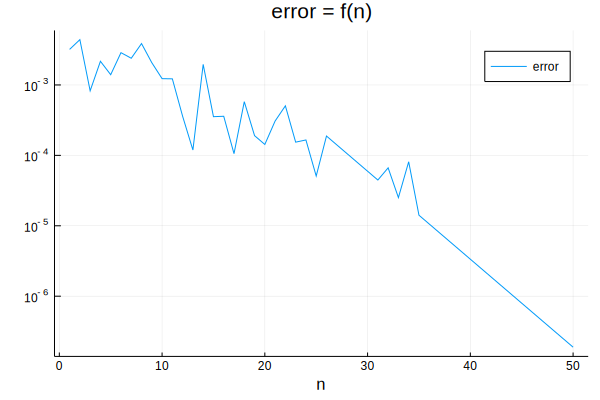

In [24]:
@assert maximum(prev_n) <= max_n + 1

cur_error = zeros(max_n)
for n in 1:max_n
  @assert n == n_list[n]
  cur_error[n] = P_list[n]
  
  if ( n in prev_n )
    tmp_index = findfirst(tmp_n -> tmp_n == n, prev_n)
    cur_error[n] -= prev_P[tmp_index]
  end
  
  cur_error[n] = abs(cur_error[n])
end

plot(
  n_list, cur_error, yscale=:log10,
  xlabel="n", title="error = f(n)", label="error"
)


#### The error between the two curves decreases exponentially with n (or tau from before)

It was introduced by the stochasticity of the process and its impact decreases as time passes

---


### 3. Write a function `cumulative_sum`, which returns a new vector. 


In [25]:
function cumulative_sum(input_list)
  output_list = collect(input_list)
  
  cur_sum = 0
  for (cur_index, cur_value) in enumerate(output_list)
    cur_sum += cur_value
    output_list[cur_index] = cur_sum
  end
  
  return output_list
end

@assert cumulative_sum(n_list) == cumsum(n_list) 
@assert cumulative_sum(P_list) == cumsum(P_list) 



### 4. Plot the resulting values on a horizontal line. 

+ Generate a few random points and plot those
+ Convince yourself that the probability that a point hits a bin is equal to the length of that bin.


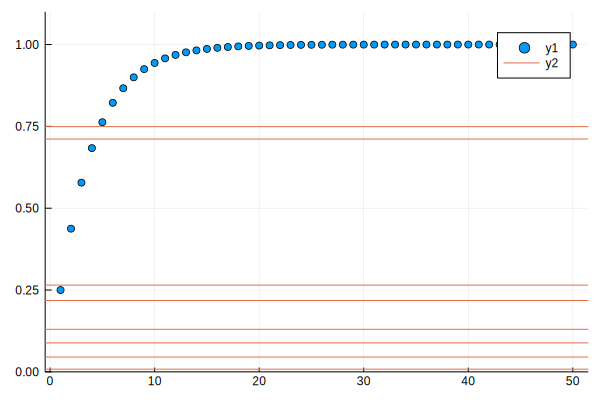

In [26]:
scatter(n_list, cumulative_sum(P_list))
hline!(rand(8))
ylims!(0,1.1)


### 5. Calculate analytically the sum of $P_1$ up to $P_n$


First part,

+ $P_n = p \cdot (1-p) ^ {n-1}$
+ $\sum_1^n P_i = p \cdot \sum_1^n (1-p) ^ {n-1} $

Second part,

+ $S_n = \sum_1^n x ^ {n-1} = 1 + x + x^2 + \cdots + x^{n-1}$
+ $S_{n+1} = x + x^2 + \cdots + x^n = x \cdot S_n$

Combining the two substeps of the second part:

+ $S_n \cdot (1-x) = (1-x^n)$
+ **or:** $S_n = \frac{1-x^n}{1-x}$

Substituting in x = 1-p, gives:

+ $S_n = \frac{1-(1-p)^n}{p}$

So now we can say,

$\sum_1^n P_i = 1-(1-p)^n $

Where two factors of **`p`**'s cancelled out

// note that because p < 1, $P_i$ tends to 1 as n goes to infinity

----


### 6. Use the result of [5] to find analytically which bin $n$ 
A given value of $r \in [0, 1]$ falls into using the inequality $P_{n-1} \le r \lt P_n$.


We start with:

+ $r = \sum_1^n P_i $
+ $r = 1-(1-p)^n $

This leads to:

+ $(1-p)^n = (1-r)$

However, **`n`** is an int defined at right end of interval, so:

> $ n = 1 + \left\lfloor \frac{log(1-r)}{log(1-p)} \right\rfloor $


### 7. Implement this using the `floor` function.

In [27]:
p = 0.25
calc_n(r, p) = Int( 1 + floor( log(1-r) / log(1-p) ) )

println("\n--------------\n a quick test\n--------------\n")
for _ in 1:10
  r = rand()
  n = calc_n(r,p)
  
  rounded_string = rpad(string(round(r, digits=2)), 4, "0")
  println("r = ", rounded_string, "   ->   n = ", n)
end


--------------
 a quick test
--------------

r = 0.55   ->   n = 3
r = 0.59   ->   n = 4
r = 0.20   ->   n = 1
r = 0.34   ->   n = 2
r = 0.81   ->   n = 6
r = 0.31   ->   n = 2
r = 0.63   ->   n = 4
r = 0.22   ->   n = 1
r = 0.44   ->   n = 3
r = 0.02   ->   n = 1


----

## Exercise 4: A simple infection model

A simple model for modeling infection and recovery is: An individual starts in state `S` ("susceptible"). When they are in state `S`, they have a probability $p_E$ to become exposed (state `E`) at each step. Once they are exposed, they have probability $p_I$ to become infectious (state `I`). When they are infectious, they have a probability $p_R$ to recover at each step.

> `S -> E -> I -> R`

----

### 1. How does the total time $\tau_\text{total}$ to go from `S` to `R` relate to these times? 

What is the relation with the geometric random variables from the previous exercises?


> $\tau_{total} = \tau_S + \tau_E + \tau_I$

Related to before, it's basically just 3 `S-I` models daisy chained together

### 2. Write a function `total_time(p_E, p_I, p_R)` that calculates the total time to go from state `S` to state `R`.



In [28]:
total_time(p...) = sum(geometric.(p))

experiment(p::Vector, N) = [ total_time(p...) for _ in 1:N ]

test_p = [1,1,1]
@assert total_time(test_p...) == 3
@assert experiment(test_p, 1) == [3]

### 3. Run a Monte Carlo simulation to:
calculate and plot the probability distribution of $\tau_\text{total}$ for:
+ $p_E = 0.25$
+ $p_I = 0.1$ 
+ $p_R = 0.05$



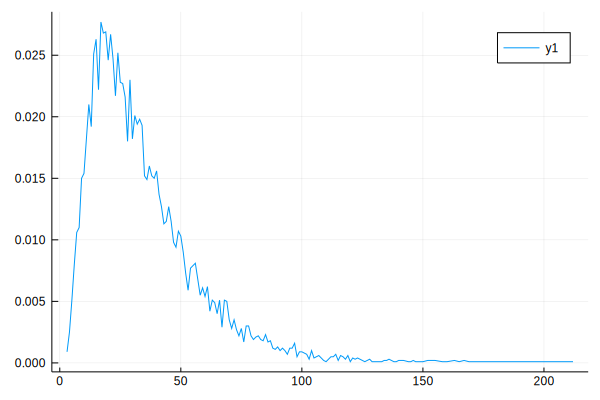

In [29]:
p_E = 0.25 
p_I = 0.10
p_R = 0.05

n_trials = 10000

plot(
  probability_distribution(experiment([p_E, p_I, p_R], N))
)


### 4. What happens to the probability distribution of the total time as you add more states?

A: The distribution first becomes a Poisson distribution and then a Gaussian (or normal)

In [30]:
n_trials = 10000

@manipulate for p=linspace(0,1,11)[2:end], n=slider(1:12, label="n", value=1)
  p_list = fill(p, n)

  xx, yy = probability_distribution(experiment(p_list, n_trials))
  
  if length(xx) == 1
    scatter(xx, yy)
  else
    plot(xx, yy)
  end
  
  xlims!(0, 1.25*maximum(xx))
  ylims!(0, 1.1)
end

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["p"], Dict{Symbol,Any}(:className => "interact ",:style => Dict{Any,Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol,Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol,Any}(:max => 10,:min => 1,:attributes => Dict{Any,Any}(:type => "range",Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}","orient" => "horizontal"),:step => 1,:className => "slider slider is-fullwidth",:style => Dict{Any,Any}()))], Dict{Symbol,Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol,Any}(:className => "interact-flex-row-right"))], Dict{Symbol,Any}(:className => "interact-flex-row interact-widget")), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing),"index" => (Observable{Any} with 2 listeners. Value:
5, nothing)), Set(String[]), nothing, Asset[Asset("js", "knockout", "/Users/dan/.julia/packages/Knockout/IP1uR/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/Users/dan/.julia/packages/Knockout/IP1uR/src/../assets/knockout_punches.js"), Asset("js", nothing, "/Users/dan/.julia/packages/InteractBase/NMcus/src/../assets/all.js"), Asset("css", nothing, "/Users/dan/.julia/packages/InteractBase/NMcus/src/../assets/style.css"), Asset("css", nothing, "/Users/dan/.julia/packages/Interact/SbgIk/src/../assets/bulma_confined.min.css")], Dict{Any,Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")],"index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(sz_max:32,sz_curr:0), Set(AbstractConnection[]), Base.GenericCondition{Base.AlwaysLockedST}(Base.InvasiveLinkedList{Task}(Task (runnable) @0x000000010e358b50, Task (runnable) @0x000000010e358b50), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"0.1\",\"0.2\",\"0.3\",\"0.4\",\"0.5\",\"0.6\",\"0.7\",\"0.8\",\"0.9\",\"1.0\"],\"changes\":WebIO.getval({\"name\":\"changes\",\"scope\":\"15655600016219785762\",\"id\":\"3102906719351478429\",\"type\":\"observable\"}),\"index\":WebIO.getval({\"name\":\"index\

### 5. **Extra credit:** Write a simulation that runs $N$ individuals and keeps track at each step of how many people are in which state. Plot the resulting graph of the number of people in the `S`,  `I`, `E` and `R` states as a function of time.


In [31]:
function make_seir_plot(N, p_E, p_I, p_R)
  
  count_dict = OrderedDict(
        :s=>[N], :e=>[0], :i=>[0], :r=>[0]
    )

    t = 1
    while count_dict[:r][t] < N
      t += 1

      for (cur_key, cur_value) in count_dict
        push!(count_dict[cur_key], cur_value[end])
      end

      new_r = count([ bernoulli(p_R) for _ in 1:count_dict[:i][t-1] ])
      count_dict[:i][t] -= new_r
      count_dict[:r][t] += new_r

      new_i = count([ bernoulli(p_I) for _ in 1:count_dict[:e][t-1] ])
      count_dict[:e][t] -= new_i
      count_dict[:i][t] += new_i

      new_e = count([ bernoulli(p_E) for _ in 1:count_dict[:s][t-1] ])
      count_dict[:s][t] -= new_e
      count_dict[:e][t] += new_e
    end

    plot(title="SEIR Model", ylabel="p [%]", xlabel="time")
    for (cur_key, cur_value) in count_dict
      plot!(cur_value ./ N, label=uppercase(string(cur_key)))
    end
    plot!(xscale=:log10)
  
end

make_seir_plot (generic function with 1 method)

In [32]:
N = 100000

using DataStructures

p_E_slider = slider(linspace(0,1,9)[2:end], value=0.25, label="p_E")
p_I_slider = slider(linspace(0,1,9)[2:end], value=0.10, label="p_I")
p_R_slider = slider(linspace(0,1,9)[2:end], value=0.05, label="p_R")

@manipulate for p_E=p_E_slider, p_I=p_I_slider, p_R=p_R_slider
  make_seir_plot(N, p_E, p_I, p_R)
end

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["p_E"], Dict{Symbol,Any}(:className => "interact ",:style => Dict{Any,Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol,Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol,Any}(:max => 8,:min => 1,:attributes => Dict{Any,Any}(:type => "range",Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}","orient" => "horizontal"),:step => 1,:className => "slider slider is-fullwidth",:style => Dict{Any,Any}()))], Dict{Symbol,Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol,Any}(:className => "interact-flex-row-right"))], Dict{Symbol,Any}(:className => "interact-flex-row interact-widget")), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing),"index" => (Observable{Any} with 2 listeners. Value:
2, nothing)), Set(String[]), nothing, Asset[Asset("js", "knockout", "/Users/dan/.julia/packages/Knockout/IP1uR/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/Users/dan/.julia/packages/Knockout/IP1uR/src/../assets/knockout_punches.js"), Asset("js", nothing, "/Users/dan/.julia/packages/InteractBase/NMcus/src/../assets/all.js"), Asset("css", nothing, "/Users/dan/.julia/packages/InteractBase/NMcus/src/../assets/style.css"), Asset("css", nothing, "/Users/dan/.julia/packages/Interact/SbgIk/src/../assets/bulma_confined.min.css")], Dict{Any,Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")],"index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(sz_max:32,sz_curr:0), Set(AbstractConnection[]), Base.GenericCondition{Base.AlwaysLockedST}(Base.InvasiveLinkedList{Task}(Task (runnable) @0x000000010dd81d50, Task (runnable) @0x000000010dd81d50), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"0.125\",\"0.25\",\"0.375\",\"0.5\",\"0.625\",\"0.75\",\"0.875\",\"1.0\"],\"changes\":WebIO.getval({\"name\":\"changes\",\"scope\":\"18276822842476609109\",\"id\":\"12852112473873830512\",\"type\":\"observable\"}),\"index\":WebIO.getval({\"name\":\"index\",\"

----

## Extra Credit: Web Dashboard

In [33]:
# load file with custom plot extractor

include("dont_manipulate.jl")


In [34]:
plotlyjs()

@dont_manipulate "../docs/assets/json/recovery-time.json" for p in linspace(0,1,11)[2:end], N=logspace(1, 10^5, 6)
  make_recovery_plot(p, N)
end

p_E_slider = slider(linspace(0,1,9)[2:end], value=0.375, label="p_E")
p_I_slider = slider(linspace(0,1,9)[2:end], value=0.250, label="p_I")
p_R_slider = slider(linspace(0,1,9)[2:end], value=0.125, label="p_R")

@dont_manipulate "../docs/assets/json/seir-model.json" for p_E=p_E_slider, p_I=p_I_slider, p_R=p_R_slider
  make_seir_plot(N, p_E, p_I, p_R)
end

gr()


<!DOCTYPE html>
 
 
 Plots.jl

Plots.GRBackend()